# Text generation with deep learning

In [15]:
import sys
import os
import os.path
import random
import collections
import shutil
import time
import glob
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import pi
import scipy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets
from torch.nn.utils.rnn import pad_sequence


%matplotlib inline

from torch.utils.data import DataLoader
import pickle

# для визуализации
# from bokeh.io import show,output_notebook
# from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
# from bokeh.models import FuncTickFormatter
# from bokeh.plotting import figure

# output_notebook()

**Задача**

   Обучить character recurrent neural network (char RNN) на датасете статей arxiv, а также на своих данных и исследовать её свойства.

Определим структуру сети, в качестве основного блока используем **GRU**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
#         print("input before encoding: ", input)
#         print("input shape before encoding: ", input.shape)
#         print("================================================")
        input = self.encoder(input.view(1, -1))
#         print("input after encoding: ", input)
#         print("input shape after encoding: ", input.shape)
#         print("================================================")
#         print("input.view(-1): ", input.view(-1))
#         print("================================================")
#         print("input.view(-1) size: ", len(input.view(-1)))
#         print("================================================")
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
#         print("gru passed")
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

In [ ]:
torch.zeros(2, 1, 10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

# Пример реализации класса для получения данных из датасета

In [ ]:
class TextDataset(Dataset):
#     def __init__(self, text, chunk_len=10, chunks_number=100):
    def __init__(self, text, chunk_len=10, chunks_number=100):
        self.chunks_number = chunks_number # количество блоков
        self.chunk_len = chunk_len  # длина одного блока (на сколько букв смотрим назад при предсказании)
        self.text = text
        self.all_symbols = list({x for x in self.text})
    
    def __len__(self):
        return self.chunks_number
    
    def _get_tensor(self, text):   # ставит в соответствие каждой букве из текста её индекс
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):   # декодирует вектор из цифр (text) в текст
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):  # берет случайный срез букв из текста
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    # 1 саммари - 100 инпутов и 100 таргетов 
    def __getitem__(self, idx):
        chunk = self._get_random_slice()  
        # self._get_tensor(chunk[:-1]) - текущее состояние, self._get_tensor(chunk[1:]) - следующее состояние (target)??
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])  # chunk[:-1] не включает последний эл-т, chunk[1:] не включает первый эл-т

# Здесь должен быть код для считывания данных и создания даталоадера

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
arxiv_dataset = pd.read_csv('/content/drive/MyDrive/Универ/arxiv.csv') 
# arxiv_dataset = pd.read_csv('arxiv.csv') 
arxiv_dataset

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0
...,...,...,...,...,...,...,...,...,...,...
27183,arxiv.org/abs/1710.04176,NaN,NaN,NaN,"[C. -C. Jay Kuo, Yueru Chen]",cs.CV,2017-10-11 17:08:28,Being motivated by the multilayer RECOS (REcti...,On Data-Driven Saak Transform,0
27184,arxiv.org/abs/1710.04177,NaN,NaN,NaN,"[Heather Mattie, Kenth Engø-Monsen, Rich Ling,...",cs.SI,2017-10-11 17:12:05,"Understanding tie strength in social networks,...",The Social Bow Tie,0
27185,arxiv.org/abs/1710.04196,NaN,NaN,NaN,"[Robin Scheibler, Eric Bezzam, Ivan Dokmanić]",cs.MS,2017-10-11 17:44:41,"We present pyroomacoustics, a software package...",Pyroomacoustics: A Python package for audio ro...,0
27186,arxiv.org/abs/1710.04200,NaN,NaN,NaN,"[Yijun Li, Jia-Bin Huang, Narendra Ahuja, Ming...",cs.CV,2017-10-11 17:56:59,Joint image filters leverage the guidance imag...,Joint Image Filtering with Deep Convolutional ...,0


In [ ]:
# torch.zeros(2, 3, 4)[0]

In [ ]:
def collate_fn(input_data):  # на вход приходит arxiv_dataset['summary']
    inputs = []
    targets = []
    for item in tqdm(input_data):
        item_ = TextDataset(item)
#         for chunks_n in range(item_.chunks_number):
#             inputs.append(item_.__getitem__(chunks_n)[0])
#             targets.append(item_.__getitem__(chunks_n)[1])
        inputs.append(item_.__getitem__(0)[0])
        targets.append(item_.__getitem__(0)[1])
#     print("collate_fn: before pad", inputs)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
#     print("collate_fn: after pad", inputs)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return {'inputs': inputs, 'targets': targets}
    # return inputs, targets

In [ ]:
collate_fn(arxiv_dataset['summary'])

In [ ]:
# dict_ = collate_fn(arxiv_dataset['summary'])

In [ ]:
# dict_['inputs'][0]

In [ ]:
# len(dict_['targets'])

In [ ]:
from torch.utils.data import DataLoader
batch_size = 1
loader = DataLoader(arxiv_dataset['summary'], 
                            batch_size, 
                            shuffle=True,
#                             num_workers=2,
                            collate_fn=collate_fn,
#                             drop_last = True,
                            )

In [ ]:
# for inputs, targets in loader:
#   print(inputs[0].size(-1))
# for i, batch in enumerate(loader):
#   print(batch['inputs'].size(-1))

Смотрим, сколько уникальных символов есть в датасете - это и будет размер выходного вектора у нейронной сети

In [ ]:
unique_symbols = []
for i in range(len(arxiv_dataset['summary'])):
    Text_Dataset = TextDataset(arxiv_dataset['summary'][i])
    for symbol in Text_Dataset.all_symbols:
        if symbol not in unique_symbols:
            unique_symbols.append(symbol)

In [ ]:
len(unique_symbols)

97

In [ ]:
# Text_Dataset = TextDataset(arxiv_dataset['summary'][5818])
# len(Text_Dataset.all_symbols)

In [ ]:
# unique_symbols = len(Text_Dataset.all_symbols)
n_layers = 2
hidden_size = 1000

In [ ]:
# torch.zeros(2, 1, 100)

In [ ]:
# unique_symbols

In [ ]:
device = torch.device("cuda")

In [ ]:
net = RNN(len(unique_symbols), hidden_size, len(unique_symbols), n_layers)

In [ ]:
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

In [105]:
hidden

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Здесь нужно реализовать функцию для генерации текста с помощью сети

In [56]:
def generate(net, device, dataset, prime_str="A", predict_len=100, temperature=0.8):
    with torch.no_grad():
        net.eval()
        predicted_string = prime_str
        hidden = net.init_hidden().cuda()
#         input_char = torch.LongTensor([dataset.all_symbols.index(prime_str)]).cuda()
        input_char = dataset._get_tensor(prime_str)

        while len(predicted_string) < predict_len:

            output, hidden = net(input_char, hidden) # генерируем продолжение строки и новый hidden
            id_of_next_char = output.argmax() # ищем номер самой вероятной буквы для продолжения
            if id_of_next_char == len(dataset.all_symbols) - 1:
                break
            next_char = dataset.all_symbols[id_of_next_char]
            predicted_string += next_char
            
#             input_char = torch.LongTensor([dataset.all_symbols.index(next_char)]).cuda()
            input_char = dataset._get_tensor(next_char)
            
        return predicted_string

In [57]:
text_dataset = TextDataset(arxiv_dataset['summary'][0], symbols, chunk_len=1)

In [58]:
generate(net, device, text_dataset)

'At wAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiAMawiA'

# Здесь должен быть цикл тренировки

In [ ]:
epochs = 100

In [ ]:
start = time.time()

net.train()
# hidden = net.init_hidden()
for epoch in range(1, epochs+1):
#     hidden = net.init_hidden().to(device)
#     hidden = torch.zeros(n_layers, 1, 1000)
    # for inputs, targets in loader:
    for i, batch in enumerate(loader):
        #Your code for training here
        # hidden = tuple(([Variable(var.data) for var in hidden]))
        optimizer.zero_grad()
        
#         print(batch['inputs'])
#         print(hidden.to(device).size(-1))
        output, hidden = net(batch['inputs'].to(device), hidden)
#         loss = criterion(output, batch['targets'].to(device))
#         loss.backward()
        optimizer.step()

print("Saving...")
RNN.save_model(net, "TrainedModel.ckpt")

In [76]:
print(len(hidden[0][0]))

100


In [19]:
inputs = torch.LongTensor([symbols.index("A")]).cuda()
net(inputs, hidden.cuda())[0].shape

torch.Size([1, 98])

In [22]:
pred = net(inputs, hidden.cuda())[0]

In [35]:
pred

tensor([[ -3.4287,   0.7673,  -5.5772,  -3.6050,  -4.0858,  -1.0775,  -5.9385,
          -4.6353,  -0.4473,   0.0648,  -5.2527,  -1.7242,  -2.6784,   0.6840,
          -4.4650,  -6.1217,  -7.1478,   0.2174,  -6.0777,  -6.3620,  -4.9229,
           0.1024,  -2.6279,  -1.6673,  -6.2317,  -1.9567,  -6.0442,  -7.3561,
          -2.5173,  -1.0740,   1.1548,  -4.7866,  -6.2299,   1.2050,  -2.9068,
          -0.7309,  -5.8618,  -4.2097,  -6.0112,  -6.4307,  -7.0132,  -5.7819,
          -5.6711,  -9.1844,  -6.2927,  -6.7617,  -9.0003,  -8.6777,  -6.7467,
          -6.3367,  -6.8252,  -6.2397,  -7.1575,  -6.9217,  -8.6735,  -6.7276,
         -10.1495,  -6.1476,  -8.1759,  -7.1865,  -5.5879,  -7.0190, -11.7084,
         -11.9192,  -6.7862, -10.6048,  -9.3374, -10.3494, -11.4785, -10.4546,
          -7.1347,  -8.8615,  -8.0262, -11.4216, -15.7779,  -8.6676, -14.3619,
         -12.7619, -10.3936, -14.1475, -13.5221, -12.7191, -10.2625, -11.6673,
         -15.2373, -14.1318, -16.4665, -12.6955, -15

In [33]:
pred.argmax()

tensor(33, device='cuda:0')

In [36]:
symbols[pred.argmax()]

'M'

In [75]:
targets[0]

NameError: name 'targets' is not defined

## Результаты тренировки

In [ ]:
print(generate(net, device, arxiv_dataset, 'In this research', 200 ), '\n')

# Здесь должны быть эксперименты с архитектурой и параметрами сети

In [2]:
device = torch.device("cuda")

In [3]:
arxiv_dataset = pd.read_csv('arxiv.csv') 
# arxiv_dataset = pd.read_csv('/content/drive/MyDrive/Универ/arxiv.csv') 
arxiv_dataset

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0
...,...,...,...,...,...,...,...,...,...,...
27183,arxiv.org/abs/1710.04176,NaN,NaN,NaN,"[C. -C. Jay Kuo, Yueru Chen]",cs.CV,2017-10-11 17:08:28,Being motivated by the multilayer RECOS (REcti...,On Data-Driven Saak Transform,0
27184,arxiv.org/abs/1710.04177,NaN,NaN,NaN,"[Heather Mattie, Kenth Engø-Monsen, Rich Ling,...",cs.SI,2017-10-11 17:12:05,"Understanding tie strength in social networks,...",The Social Bow Tie,0
27185,arxiv.org/abs/1710.04196,NaN,NaN,NaN,"[Robin Scheibler, Eric Bezzam, Ivan Dokmanić]",cs.MS,2017-10-11 17:44:41,"We present pyroomacoustics, a software package...",Pyroomacoustics: A Python package for audio ro...,0
27186,arxiv.org/abs/1710.04200,NaN,NaN,NaN,"[Yijun Li, Jia-Bin Huang, Narendra Ahuja, Ming...",cs.CV,2017-10-11 17:56:59,Joint image filters leverage the guidance imag...,Joint Image Filtering with Deep Convolutional ...,0


In [60]:
str = ["abcdefghi"]
str[:,5]

TypeError: list indices must be integers or slices, not tuple

In [4]:
class TextDataset(Dataset):
    def __init__(self, text, input_dict=None, chunk_len=10, chunks_number=100):
        self.chunks_number = chunks_number # количество блоков
        self.chunk_len = chunk_len  # длина одного блока (на сколько букв смотрим назад при предсказании)
        self.text = text
        # self.all_symbols = list({x for x in self.text})
        if input_dict == None:
            self.all_symbols = list({x for x in self.text})
        else:
            self.all_symbols = input_dict
    
    def __len__(self): # возвращает число чанков (случайных слайсов по тексту?)
        return self.chunks_number
    
    def _get_tensor(self, text):   # ставит в соответствие каждой букве из текста её индекс
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):   # декодирует вектор из цифр (text) в текст
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):  # берет случайный срез букв из текста
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
#         print("start: ", start_index, "end: ", end_index)
        return self.text[start_index:end_index]
    
    # 1 саммари - 100 инпутов и 100 таргетов 
    def __getitem__(self, idx):
#         print("==========================================")
        chunk = self._get_random_slice()
#         print("text:", self.text)
#         print("chunk:", chunk)
#         print("symbols:")
#         for symb in self.all_symbols:
#             print(self._get_tensor(symb), symb)
        # self._get_tensor(chunk[:-1]) - текущее состояние, self._get_tensor(chunk[1:]) - следующее состояние (target)??
        if len(chunk) == self.chunk_len + 1: # стандартное поведение
#             print("check passed, return:", self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:]))
            return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])  # chunk[:-1] не включает последний эл-т, chunk[1:] не включает первый эл-т
        else: # попали на последний символ
            # print("check unpassed, return:", torch.LongTensor([self.all_symbols.index(char) for char in chunk]).cuda(), torch.LongTensor([self.all_symbols.index(char) for char in chunk[1:]] + [97]).cuda())
            return torch.LongTensor([self.all_symbols.index(char) for char in chunk]).cuda(), torch.LongTensor([self.all_symbols.index(char) for char in chunk[1:]] + [97]).cuda()
#             return torch.LongTensor([str.all_symbols.index(char) for char in text] + [99]).cuda()

In [5]:
symbols = []
for i in range(len(arxiv_dataset['summary'])):
    Text_Dataset = TextDataset(arxiv_dataset['summary'][i])
    for symbol in Text_Dataset.all_symbols:
        if symbol not in symbols:
            symbols.append(symbol)

symbols.append('')

In [6]:
len(symbols)

98

In [94]:
# params
unique_symbols = len(symbols)
n_layers = 2
hidden_size = 100
epochs = 50
chunk_len = 10
batch_size = 100

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        # input_size (==unique_symbols) – size of the dictionary of embeddings
        # hidden_size – the size of each embedding vector
        # Вход: (*) IntTensor или LongTensor произвольной формы, содержащие индексы для извлечения
        # Output: (∗, H), where * is the input shape and H = hidden_size
        
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, inputs, hidden):
#         print("input before encoding: ", inputs)
#         print("input shape before encoding: ", input.shape)
#         print("================================================")
        inputs = self.encoder(inputs.view(1, -1))
        # Embedding — кажому элементу из input-а ставит некоторое векторное представление размера hidden_size
        # Например, если пришёл один тензор из 10 элементов (10 закодированных символов char), то кажому из этих 10 элементов будет поставлен в соответствии вектор размера hidden_size 
        # вернёт тензор второй вложенности размера len(inputs) * hidden_size
#         print("input after encoding: ", inputs)
#         print("input shape after encoding: ", input.shape)
#         print("================================================")
#         print("input.view(-1): ", input.view(-1))
#         print("================================================")
#         print("input.view(-1) size: ", len(input.view(-1)))
#         print("================================================")
        output, hidden = self.gru(inputs.view(1, 1, -1), hidden)
#         print("gru passed")
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

In [81]:
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)

net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

In [150]:
def collate_fn(input_data, device=torch.device("cuda")):  # на вход приходит arxiv_dataset['summary']
    inputs = []
    targets = []
    for item in input_data:
#         for chunks_n in range(item_.chunks_number):
#             inputs.append(item_.__getitem__(chunks_n)[0])
#             targets.append(item_.__getitem__(chunks_n)[1])
        # torch.zeros(len(line), 1, n_letters)
        
        item_ = TextDataset(item, symbols)
        line = item_.__getitem__(0)
        
#         input_tensor = torch.zeros(item_.chunk_len, 1, len(item_.all_symbols)).int()
#         target_tensor = torch.zeros(item_.chunk_len, 1, len(item_.all_symbols)).int()
        
        input_tensor = torch.zeros(len(item_.all_symbols)).int()
        target_tensor = torch.zeros(len(item_.all_symbols)).int()
    
#         for li in range(item_.chunk_len):
#             letter = line[li]
#             input_tensor[li][0][item_.all_symbols.index(letter)] = 1
#         for li in range(item_.chunk_len):
#             input_tensor[li][0][line[0][li]] = 1
#             target_tensor[li][0][line[1][li]] = 1
        for li in range(item_.chunk_len):
            input_tensor[line[0][li]] = 1
            target_tensor[line[1][li]] = 1
            
        inputs.append(input_tensor)
        targets.append(target_tensor)
        
#         inputs.append(item_[0])
#         targets.append(item_[1])
#     print("collate_fn before pad:", inputs, targets)

    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    
    # pad_sequence - возвращает Tensor размерности T x B x * or B x T x * (если batch_first=True)
    # B это batch size. (Он равен количеству элементов в sequence)
    # T длина наибольшей sequence. 
    # L длина sequence. 
    #* любое кол-во конечных измерений, включая none.
    
#     print("collate_fn after pad:", inputs, targets)
    return {'inputs': inputs.to(device), 'targets': targets.to(device)}
    # return inputs, targets

In [151]:
collate_fn(arxiv_dataset["summary"][:2])

{'inputs': tensor([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
          0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
          0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
          0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     

In [148]:
test = torch.zeros(3, 5) # массив вложенности 2?
test[0][0]=5
test[1][1]=5
test[1][2]=7
test

tensor([[5., 0., 0., 0., 0.],
        [0., 5., 7., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [149]:
test[:,2]

tensor([0., 7., 0.])

In [134]:
collate_fn(arxiv_dataset["summary"][:2])

{'inputs': tensor([[[[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]]],
 
 
         [[[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([[[[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]]],
 
 
         [[[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          [[0, 0, 0,  ..., 0, 0, 0]],
 
          ...,
 
          [[0, 0, 0,  ..., 0

In [99]:
loader = DataLoader(arxiv_dataset['summary'], 
                            batch_size, # как много sample загружать за 1 батч
#                             shuffle=True, # перетасовка данных между эпохами
#                             num_workers=2,
                            collate_fn=collate_fn, # функция-обработчик датасета (объединяет список сэмплов, чтобы сформировать мини-партию тензоров)
#                             drop_last = True, # удалять ли последний незавершённый batch (если размер датасета не делится на batch_size)
                            )

In [100]:
start = time.time()

losses_avg = []
losses_best = []
net.train()
# hidden = net.init_hidden()
for epoch in range(1, epochs+1):
    print('epoch: ', epoch)
    losses = []
    hidden = net.init_hidden().to(device)
#     hidden = torch.zeros(n_layers, 1, 1000)
    # for inputs, targets in loader:
    for i, batch in enumerate(tqdm(loader)):
#         print("i:", i)
        hidden = hidden.detach()
        # hidden = tuple(([Variable(var.data) for var in hidden]))
        optimizer.zero_grad()
        for mini_batch in range(batch_size):
            batch["inputs"][mini_batch]
                for c in range(chunk_len):
            output, hidden = net(batch['inputs'][:,c], hidden)
            loss = criterion(output, torch.flatten(batch['targets']).to(device))
#         print(batch['inputs'])
#         print(hidden.to(device).size(-1))
        output, hidden = net(batch['inputs'].to(device), hidden)
#         loss = criterion(output, torch.flatten(batch['targets']).to(device))
        loss = criterion(output, torch.flatten(batch['targets']).to(device))
      
        loss.backward()
        optimizer.step()
        
        loss = loss.cpu().detach().numpy()
        
        # print(type(loss))
        # print("loss: ", loss)
        losses.append(loss)
        # print(losses[0])
    
    # print('losses: ', losses)
    losses_avg.append(np.mean(losses))
    # print(np.mean(losses))
    # print(losses[0], np.mean(losses))
    losses_best.append(sorted(losses, reverse=False)[0])  # reverse=False - в порядке возрастания

    if epoch%10 == 0:
        print("Saving...")
#         RNN.save_model(net, f'/content/drive/MyDrive/Универ/TrainedModel_epoch_{epoch}.ckpt')
        RNN.save_model(net, f'TrainedModel_epoch_{epoch}.ckpt')

epoch:  1


  0%|                                                                                          | 0/272 [00:00<?, ?it/s]


RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

### Сохранение посчитанных данных

In [69]:
# # with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'wb') as f: # сохранение в бинарном формате
# with open(r'losses_avg.pkl', 'wb') as f:
#     pickle.dump(losses_avg, f)
# # with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'wb') as f: # сохранение в бинарном формате
# with open(r'losses_best.pkl', 'wb') as f:
#     pickle.dump(losses_best, f)
# with open(r'hidden.pkl', 'wb') as f:
#     pickle.dump(hidden, f)

In [16]:
# with open(r'/content/drive/MyDrive/Универ/losses_avg.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'losses_avg.pkl', 'rb') as f:
    losses_avg = pickle.load(f)
# with open(r'/content/drive/MyDrive/Универ/losses_best.pkl', 'rb') as f: # сохранение в бинарном формате
with open(r'losses_best.pkl', 'rb') as f:
    losses_best = pickle.load(f)
losses_best = [i.tolist() for i in losses_best]
with open(r'hidden.pkl', 'rb') as f:
    hidden = pickle.load(f)

In [18]:
net = RNN.load_model("TrainedModel_epoch_50.ckpt")
net = net.to(device)

### Вывод графиков loss

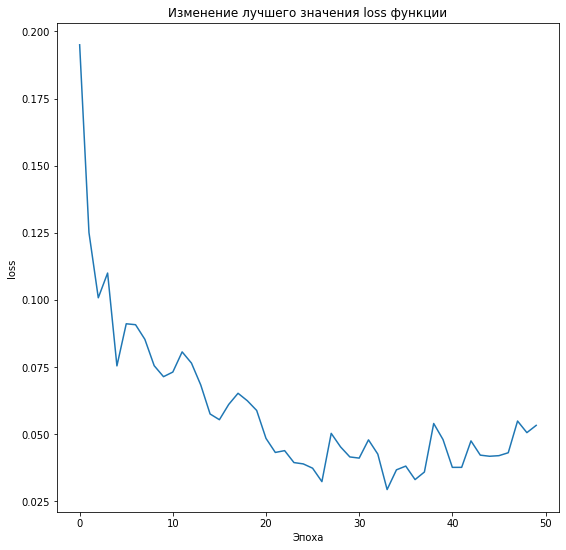

In [46]:
plt.figure(figsize=(9, 9))
plt.title("Изменение лучшего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(losses_best)
plt.show()

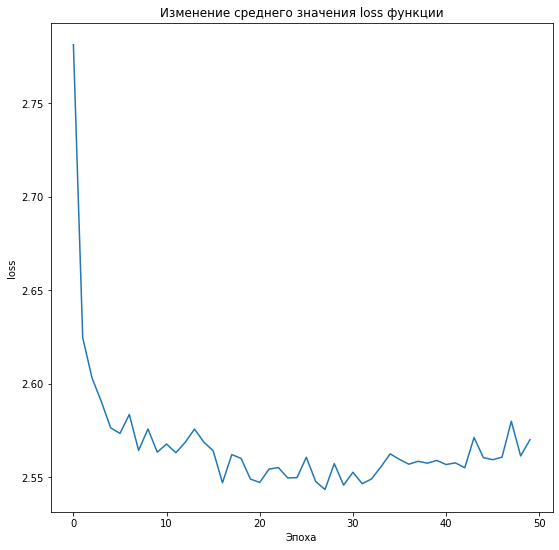

In [44]:
plt.figure(figsize=(9, 9))
plt.title("Изменение среднего значения loss функции")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.plot(losses_avg)
plt.show()

Выведем лучшие значения loss функции, а также эпоху, на которой они были достигнуты.

In [67]:
print("Лучшее значение loss:", min(losses_best),"получено на эпохе:", losses_best.index(min(losses_best)))
print("Лучшее среднее значение loss:", min(losses_avg),"получено на эпохе:", losses_avg.index(min(losses_avg)))

Лучшее значение loss: 0.02929740585386753 получено на эпохе: 33
Лучшее среднее значение loss: 2.5432336 получено на эпохе: 27


Как видно по графикам, обучение дольше 35-ти эпох не принесло особых улучшений, так как средний и лучший (по эпохе) loss остался примерно на том же уровне.

# Здесь будет работа с вашими датасетами (которые вы захотите использовать)